Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2022/2023  
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Druga laboratorijska vježba: Linearni diskriminativni modeli i logistička regresija

*Verzija: 1.1 (ispravljena greška u tekstu prvog zadatka)  
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2022 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **6. studenog 2022. u 23:59h**

------------------------------

### Upute

Druga laboratorijska vježba sastoji se od šest zadataka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [557]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\ursac\AppData\Roaming\Python\Python39\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['clf', 'poly']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [558]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Linearna regresija kao klasifikator

U prethodnoj laboratorijskoj vježbi koristili smo model linearne regresije za, naravno, regresiju. Međutim, model linearne regresije može se koristiti i za **klasifikaciju**. Iako zvuči pomalo kontraintuitivno, zapravo je dosta jednostavno. Naime, cilj je naučiti funkciju $f(\mathbf{x})$ koja za pozitivne primjere predviđa vrijednost $1$, dok za negativne primjere predviđa vrijednost $0$. U tom slučaju, funkcija $f(\mathbf{x})=0.5$ predstavlja granicu između klasa, tj. primjeri za koje vrijedi $h(\mathbf{x})\geq 0.5$ klasificiraju se kao pozitivni, dok se ostali klasificiraju kao negativni.

Klasifikacija pomoću linearne regresije implementirana je u razredu [`RidgeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html). U sljedećim podzadatcima **istrenirajte** taj model na danim podatcima i **prikažite** dobivenu granicu između klasa. Pritom isključite regularizaciju ($\alpha = 0$, odnosno `alpha=0`). Također i ispišite **točnost** vašeg klasifikacijskog modela (smijete koristiti funkciju [`metrics.accuracy_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)). Skupove podataka vizualizirajte korištenjem pomoćne funkcije ``plot_clf_problem(X, y, h=None)`` koja je dana na početku ove bilježnice. `X` i `y` predstavljaju ulazne primjere i oznake, dok `h` predstavlja funkciju predikcije modela (npr. `model.predict`). 

U ovom zadatku cilj je razmotriti kako se klasifikacijski model linearne regresije ponaša na linearno odvojim i neodvojivim podatcima.

In [559]:
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import accuracy_score

### (a)

Prvo, isprobajte *ugrađeni* model na linearno odvojivom skupu podataka `seven` ($N=7$).

In [560]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

In [561]:
h = RidgeClassifier(alpha=0).fit(seven_X, seven_y).predict(seven_X)
accuracy_score(seven_y, h)

1.0

Kako bi se uvjerili da se u isprobanoj implementaciji ne radi o ničemu doli o običnoj linearnoj regresiji, napišite kôd koji dolazi do jednakog rješenja korištenjem isključivo razreda [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Funkciju za predikciju, koju predajete kao treći argument `h` funkciji `plot_2d_clf_problem`, možete definirati lambda-izrazom: `lambda x : model.predict(x) >= 0.5`.

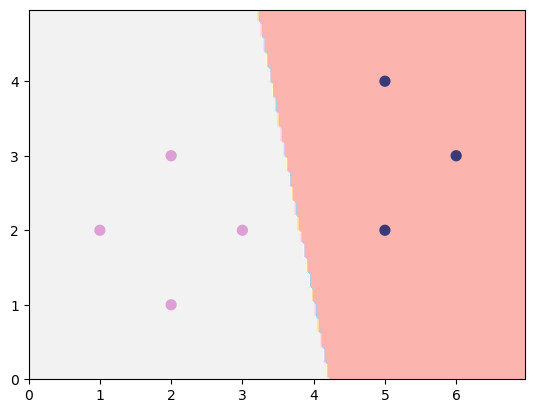

In [562]:
h = LinearRegression().fit(seven_X, seven_y)
plot_2d_clf_problem(seven_X, seven_y, lambda x : h.predict(x) >= 0.5)

**Q:** Kako bi bila definirana granica između klasa ako bismo koristili oznake klasa $-1$ i $1$ umjesto $0$ i $1$?

### (b)  

Probajte isto na linearno odvojivom skupu podataka `outlier` ($N=8$):

In [563]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

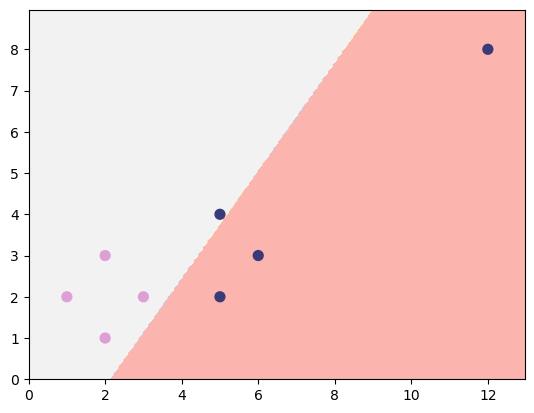

In [564]:
h = LinearRegression().fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, lambda x : h.predict(x) >= 0.5)

**Q:** Zašto model ne ostvaruje potpunu točnost iako su podatci linearno odvojivi?

### (c)  

Završno, probajte isto na linearno neodvojivom skupu podataka `unsep` ($N=8$):

In [565]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

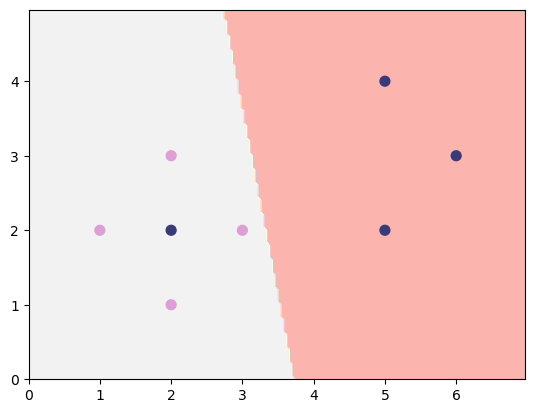

In [566]:
h = LinearRegression().fit(unsep_X, unsep_y)
plot_2d_clf_problem(unsep_X, unsep_y, lambda x : h.predict(x) >= 0.5)

**Q:** Očito je zašto model nije u mogućnosti postići potpunu točnost na ovom skupu podataka. Međutim, smatrate li da je problem u modelu ili u podacima? Argumentirajte svoj stav.

### 2. Višeklasna klasifikacija

Postoji više načina kako se binarni klasifikatori mogu se upotrijebiti za višeklasnu klasifikaciju. Najčešće se koristi shema tzv. **jedan-naspram-ostali** (engl. *one-vs-rest*, OVR), u kojoj se trenira po jedan klasifikator $h_j$ za svaku od $K$ klasa. Svaki klasifikator $h_j$ trenira se da razdvaja primjere klase $j$ od primjera svih drugih klasa, a primjer se klasificira u klasu $j$ za koju je $h_j(\mathbf{x})$ maksimalan.

Pomoću funkcije [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) generirajte slučajan dvodimenzijski skup podataka od tri klase i prikažite ga koristeći funkciju `plot_2d_clf_problem`. Radi jednostavnosti, pretpostavite da nema redundantnih značajki te da je svaka od klasa "zbijena" upravo u jednu grupu.

[[-1.60786413e-02  4.45251656e-01]
 [-1.34512226e+00 -8.43745211e-01]
 [-1.03903747e+00 -9.44354145e-01]
 [-1.02903875e+00  1.18602677e+00]
 [-8.25464233e-01 -1.20579604e+00]
 [ 1.58136539e+00  6.47338758e-01]
 [-1.36085736e+00  1.34949198e+00]
 [-6.28136594e-01  1.03411764e+00]
 [-1.44107174e+00 -9.95913479e-01]
 [ 1.14026360e+00  7.70133409e-01]
 [ 1.05673968e+00  8.80962181e-01]
 [-9.41761512e-01  1.05981183e+00]
 [-9.93642623e-01 -3.91488738e-01]
 [-7.25587049e-01  9.10618684e-01]
 [-1.29227567e+00  3.30199088e-02]
 [-3.22141770e-01  8.19911705e-01]
 [ 7.48828827e-01  1.28720131e+00]
 [-1.40335129e+00 -7.40517390e-02]
 [ 2.32707197e-01  9.13135722e-01]
 [ 2.36929861e+00  7.56445355e-01]
 [ 2.19661254e+00  7.26804303e-01]
 [ 8.86910133e-01  8.11481838e-01]
 [ 4.10296106e-03  9.32575064e-01]
 [-4.35140640e-01 -1.17100031e+00]
 [-2.34880214e+00  1.36213521e+00]
 [ 1.30243981e+00  1.18195544e+00]
 [ 7.25982615e-01  9.45649111e-01]
 [-1.46451923e+00  1.38250139e+00]
 [-1.66292434e+00 -4

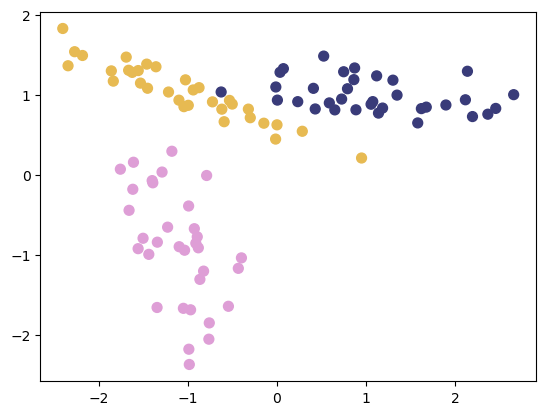

In [567]:
from sklearn.datasets import make_classification

X, Y = make_classification(n_features=2, n_redundant=0, n_classes=3,  n_clusters_per_class=1)
print(X)
print(Y)
plot_2d_clf_problem(X, Y)

Trenirajte tri binarna klasifikatora, $h_1$, $h_2$ i $h_3$ te prikažite granice između klasa (tri grafikona). Zatim definirajte $h(\mathbf{x})=\mathrm{argmax}_j h_j(\mathbf{x})$  (napišite svoju funkciju `predict` koja to radi) i prikažite granice između klasa za taj model. Zatim se uvjerite da biste identičan rezultat dobili izravno primjenom modela `RidgeClassifier`, budući da taj model za višeklasan problem zapravo interno implementira shemu jedan-naspram-ostali.

**Q:** Alternativna shema jest ona zvana **jedan-naspram-jedan** (engl, *one-vs-one*, OVO). Koja je prednost sheme OVR nad shemom OVO? A obratno?

In [568]:
#razdvojiti klase
Y1 = np.array([])
Y2 = np.array([])
Y3 = np.array([])

for y in Y:
    if y == 0:
        Y1 = np.append(Y1, 1)
        Y2 = np.append(Y2, 0)
        Y3 = np.append(Y3, 0)
    elif y == 1:
        Y1 = np.append(Y1, 0)
        Y2 = np.append(Y2, 1)
        Y3 = np.append(Y3, 0)
    elif y == 2:
        Y1 = np.append(Y1, 0)
        Y2 = np.append(Y2, 0)
        Y3 = np.append(Y3, 1)

h1 = LinearRegression().fit(X, Y1)
h2 = LinearRegression().fit(X, Y2)
h3 = LinearRegression().fit(X, Y3)

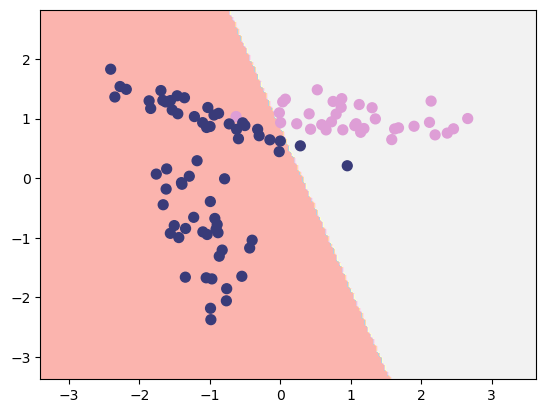

In [569]:
plot_2d_clf_problem(X, Y1, lambda x : h1.predict(x) >= 0.5)

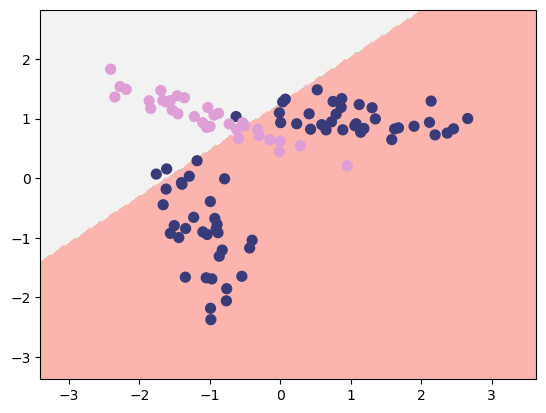

In [570]:
plot_2d_clf_problem(X, Y2, lambda x : h2.predict(x) >= 0.5)

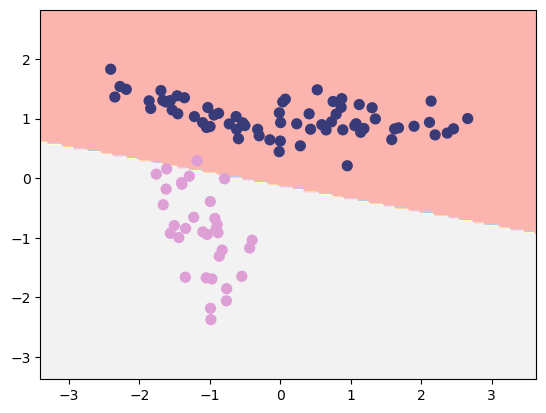

In [571]:
plot_2d_clf_problem(X, Y3, lambda x : h3.predict(x) >= 0.5)

In [572]:
def my_predict(x):
    arr = np.array([])
    for i in range(len(x)):
        arr = np.append(arr, np.argmax([h1.predict(x)[i], h2.predict(x)[i], h3.predict(x)[i]]))
    return arr
                                        

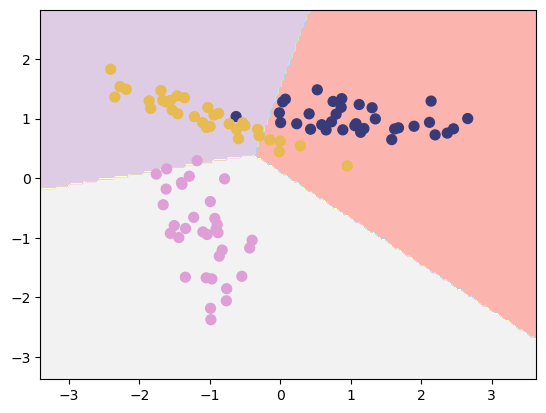

In [573]:
plot_2d_clf_problem(X, Y, lambda x : my_predict(x))

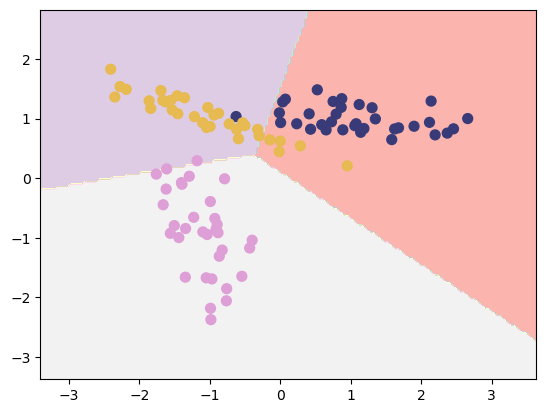

In [574]:
h = RidgeClassifier().fit(X, Y)
plot_2d_clf_problem(X, Y, lambda x : h.predict(x))

### 3. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

In [575]:
def sigm(x):
    return 1/(1 + np.exp(-x))

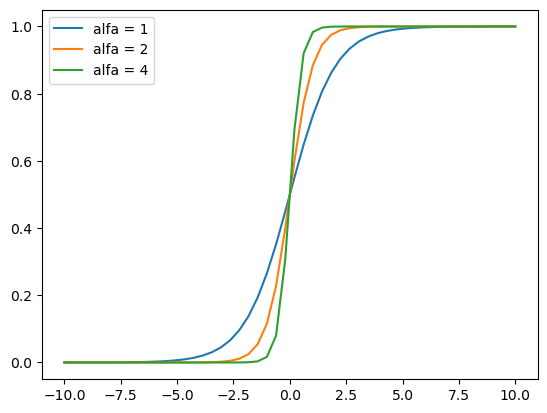

In [576]:
alfa = [1, 2, 4]
X = np.linspace(-10, 10)

plt.figure()
for a in alfa:
    plt.plot(X, sigm(a*X), label="alfa = {}".format(a))

plt.legend()
        

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [577]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import add_dummy_feature

def lr_h(x, w):
    fi = PolynomialFeatures(1).fit_transform(x.reshape(1, -1))
    return fi.dot(w)

def lr_h2(x, w):
    fi = PolynomialFeatures(1).fit_transform(x)
    return fi.dot(w)

def cross_entropy_error(X, y, w):
    fi = PolynomialFeatures(1).fit_transform(X)
    return log_loss(y, sigm(fi.dot(w)))

In [578]:
from numpy import linalg
from sklearn.preprocessing import PolynomialFeatures

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    w_tilda = np.zeros(len(X[0]) + 1)
    cee_prev = 100
    cee_curr = 1
    curr_iter = max_iter
    w_trace = []
    
    while (abs(cee_prev - cee_curr) > epsilon) and (curr_iter > 0):
        curr_iter -= 1
        w0_grad = 0
        w_grad = np.zeros(len(X[0]))
        for i in range(len(X)):
            h = sigm(lr_h(X[i], w_tilda))
            w0_grad = np.subtract(w0_grad, np.subtract(h, y[i]))
            w_grad = np.subtract(w_grad, np.dot(np.squeeze(np.array([np.subtract(h, y[i])])), np.squeeze(X[i])))
        
        w_tilda[0] = np.add(w_tilda[0], eta*w0_grad)
        w_tilda[1:] = np.add(w_tilda[1:]*(1 - eta*alpha), eta*w_grad)
        
        w_trace.append(w_tilda.copy())
        
        cee_prev = cee_curr
        cee_curr = cross_entropy_error(X, y, w_tilda)
        
    if trace: return w_tilda, w_trace, cee_curr
    else: return w_tilda, cee_curr

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [579]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

0.13521872720206746


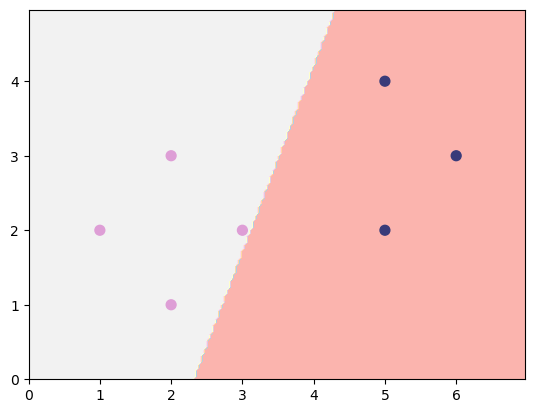

In [580]:
w, cee = lr_train(seven_X, seven_y)
print(cee)
plot_2d_clf_problem(seven_X, seven_y, h=lambda x : lr_h(x, w) >= 0.5)

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

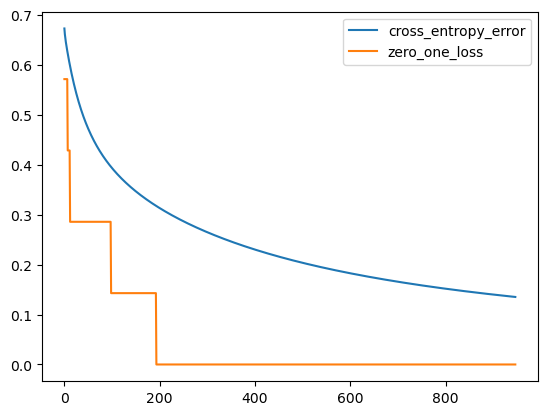

In [581]:
from sklearn.metrics import zero_one_loss
_, w_trace, _ = lr_train(seven_X, seven_y, trace=True)

h = lambda x : x >= 0.5
fi = PolynomialFeatures(1).fit_transform(seven_X)
cee = []
zol = []
for w in w_trace:
    cee.append(cross_entropy_error(seven_X, seven_y, w))
    zol.append(zero_one_loss(seven_y, h(sigm(fi.dot(w)))))
    
plt.plot(range(len(w_trace)), cee, label="cross_entropy_error")
plt.plot(range(len(w_trace)), zol, label="zero_one_loss")

plt.legend()
    

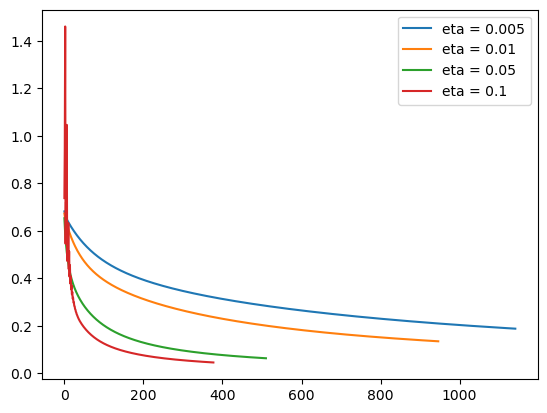

In [582]:
mi_list = [0.005, 0.01, 0.05 , 0.1]
cee_list = []

for mi in mi_list:
    _, w_trace, _ = lr_train(seven_X, seven_y, eta=mi, trace=True)
    for w in w_trace:
        cee_list.append(cross_entropy_error(seven_X, seven_y, w))
    plt.plot(range(len(w_trace)), cee_list, label="eta = {}".format(mi))
    cee_list.clear()

plt.legend();



**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

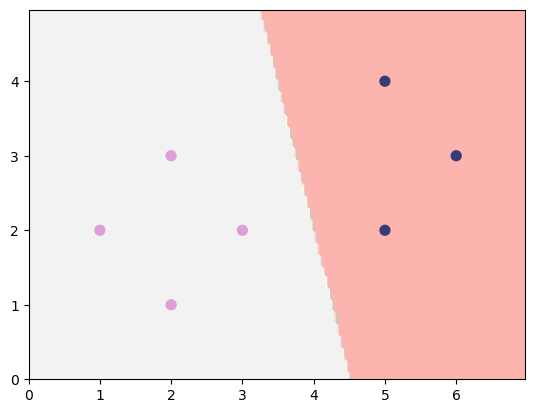

In [583]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression().fit(seven_X, seven_y)
w = clf.coef_
plot_2d_clf_problem(seven_X, seven_y, h=lambda x : clf.predict(x) >= 0.5)

### 4. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [584]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

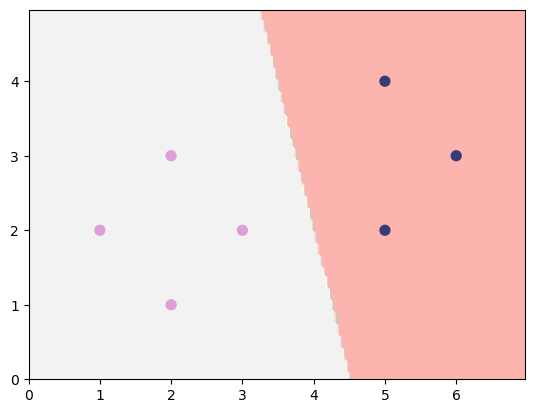

In [585]:
clf = LogisticRegression().fit(outlier_X, outlier_y)
w = clf.coef_
plot_2d_clf_problem(seven_X, seven_y, h=lambda x : clf.predict(x) >= 0.5)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

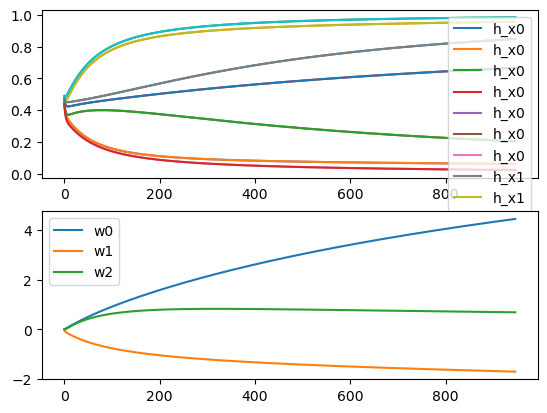

In [586]:
_, w_trace, _ = lr_train(seven_X, seven_y, trace=True)
fi = PolynomialFeatures(1).fit_transform(seven_X)

w0 = []
w1 = []
w2 = []

fig, (ax1, ax2) = plt.subplots(2)

X_size = len(seven_X[0])
h_trace = []
for w in w_trace:
    w0.append(w[0])
    w1.append(w[1])
    w2.append(w[2])
    h_trace.append(sigm(fi.dot(w)))
        
for i in range(X_size):
    ax1.plot(range(len(w_trace)), h_trace, label="h_x{}".format(i))
ax1.legend()

ax2.plot(range(len(w_trace)), w0, label="w0")
ax2.plot(range(len(w_trace)), w1, label="w1")
ax2.plot(range(len(w_trace)), w2, label="w2")
ax2.legend()
    

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [587]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

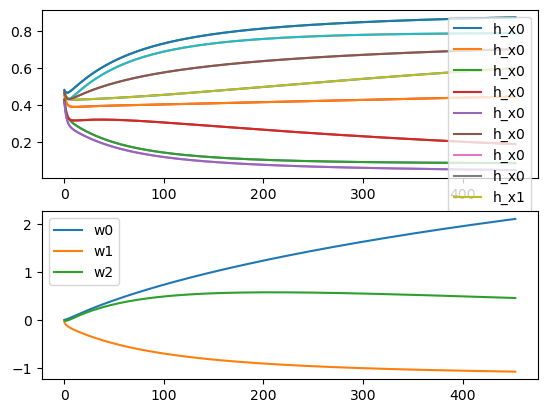

In [588]:
_, w_trace, _ = lr_train(unsep_X, unsep_y, trace=True)
fi = PolynomialFeatures(1).fit_transform(unsep_X)

w0 = []
w1 = []
w2 = []

fig, (ax1, ax2) = plt.subplots(2)

X_size = len(unsep_X[0])
h_trace = []
for w in w_trace:
    w0.append(w[0])
    w1.append(w[1])
    w2.append(w[2])
    h_trace.append(sigm(fi.dot(w)))
        
for i in range(X_size):
    ax1.plot(range(len(w_trace)), h_trace, label="h_x{}".format(i))
ax1.legend()

ax2.plot(range(len(w_trace)), w0, label="w0")
ax2.plot(range(len(w_trace)), w1, label="w1")
ax2.plot(range(len(w_trace)), w2, label="w2")
ax2.legend()

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 5. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [589]:
from numpy.linalg import norm

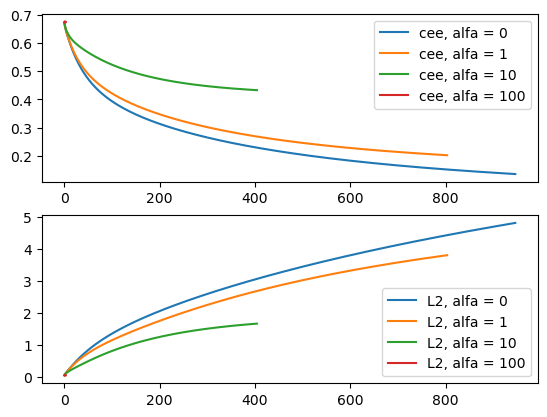

In [590]:
alfa = [0, 1, 10, 100]
cee_list = []
l2_norm = []

fig, (ax1, ax2) = plt.subplots(2)

for a in alfa:
    _, w_trace, _ = lr_train(seven_X, seven_y, alpha=a, trace=True)
    for w in w_trace:
        cee_list.append(cross_entropy_error(seven_X, seven_y, w))
        l2_norm.append(norm(w))
        
    ax1.plot(range(len(w_trace)), cee_list, label="cee, alfa = {}".format(a))
    ax1.legend()
    
    ax2.plot(range(len(w_trace)), l2_norm, label="L2, alfa = {}".format(a))
    ax2.legend()
    
    cee_list.clear()
    l2_norm.clear()


**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 6. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [591]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification

X, y = make_classification(n_features=2, n_redundant=0)

poly_2d = PolynomialFeatures(2)
poly_3d = PolynomialFeatures(3)

fi_2d = poly_2d.fit_transform(X)
fi_3d = poly_3d.fit_transform(X)

clf_2d = LogisticRegression()
clf_3d = LogisticRegression()

model_2d = clf_2d.fit(fi_2d, y)
model_3d = clf_3d.fit(fi_3d, y)

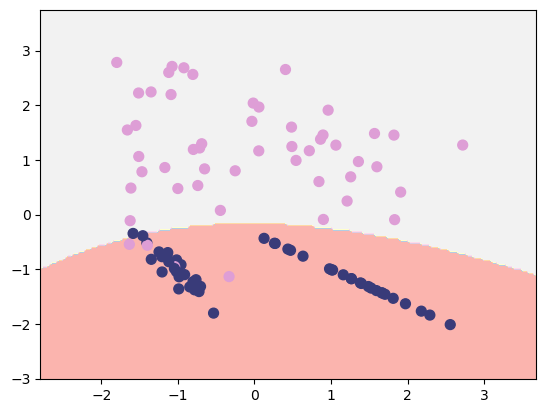

In [592]:
plot_2d_clf_problem(X, y, lambda x : model_2d.predict(poly_2d.transform(x)))

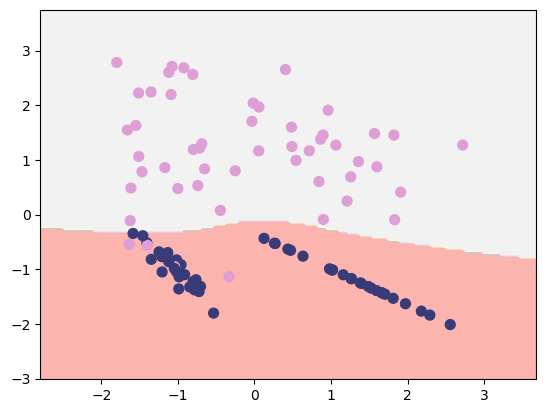

In [593]:
plot_2d_clf_problem(X, y, lambda x : model_3d.predict(poly_3d.transform(x)))

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?